# Import

In [1]:
# %pip install pytorch-lightning

In [2]:
import numpy as np
from tqdm.notebook import tqdm

In [3]:
import pytorch_lightning as pl

In [4]:
import os
from collections import namedtuple
from torchvision.utils import make_grid

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
import torchvision.transforms as transforms
from torchvision import datasets
from torchvision.models import VGG16_Weights

# LPIPS Loss

In [6]:
class VGG16(torch.nn.Module):
    def __init__(self, requires_grad=False):
        super().__init__()
        # Load pretrained vgg model from torchvision
        vgg_pretrained_features = torchvision.models.vgg16(
            weights=VGG16_Weights.IMAGENET1K_V1
        ).features
        self.slice1 = torch.nn.Sequential()
        self.slice2 = torch.nn.Sequential()
        self.slice3 = torch.nn.Sequential()
        self.slice4 = torch.nn.Sequential()
        self.slice5 = torch.nn.Sequential()
        self.N_slices = 5
        for x in range(4):
            self.slice1.add_module(str(x), vgg_pretrained_features[x])
        for x in range(4, 9):
            self.slice2.add_module(str(x), vgg_pretrained_features[x])
        for x in range(9, 16):
            self.slice3.add_module(str(x), vgg_pretrained_features[x])
        for x in range(16, 23):
            self.slice4.add_module(str(x), vgg_pretrained_features[x])
        for x in range(23, 30):
            self.slice5.add_module(str(x), vgg_pretrained_features[x])

        # Freeze vgg model
        if not requires_grad:
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, X):
        # Return output of vgg features
        h = self.slice1(X)
        h_relu1_2 = h
        h = self.slice2(h)
        h_relu2_2 = h
        h = self.slice3(h)
        h_relu3_3 = h
        h = self.slice4(h)
        h_relu4_3 = h
        h = self.slice5(h)
        h_relu5_3 = h
        vgg_outputs = namedtuple("VggOutputs", ['relu1_2', 'relu2_2', 'relu3_3', 'relu4_3', 'relu5_3'])
        out = vgg_outputs(h_relu1_2, h_relu2_2, h_relu3_3, h_relu4_3, h_relu5_3)
        return out

In [7]:
class NetLinLayer(nn.Module):
    """A single linear layer which does a 1x1 conv"""
    def __init__(self, in_channels: int, out_channels: int = 1, use_dropout: bool = False):
        super().__init__()

        self.model = nn.Sequential(
            nn.Dropout() if use_dropout else nn.Identity(),
            nn.Conv2d(in_channels, out_channels, 1, stride=1, padding=0, bias=False),
        )

    def forward(self, x):
        out = self.model(x)
        return out

In [8]:
class ScalingLayer(nn.Module):
    def __init__(self):
        super(ScalingLayer, self).__init__()
        # Imagnet normalization for (0-1)
        # mean = [0.485, 0.456, 0.406]
        # std = [0.229, 0.224, 0.225]
        self.register_buffer('shift', torch.Tensor([-.030, -.088, -.188])[None, :, None, None])
        self.register_buffer('scale', torch.Tensor([.458, .448, .450])[None, :, None, None])
    
    def forward(self, inputs):
        return (inputs - self.shift) / self.scale

In [9]:
class LPIPS(nn.Module):
    def __init__(
        self,
        use_dropout: bool = True,
        state_dict_path: str = None,
    ):
        super().__init__()
        # Imagenet normalization
        self.vgg = VGG16()
        self.scaling_layer = ScalingLayer()

        # Instantiate vgg model
        self.channels = [64, 128, 256, 512, 512]
        self.L = len(self.channels)

        # Add 1x1 convolutional Layers
        self.lins = nn.ModuleList([
            NetLinLayer(channel, 1, use_dropout=use_dropout)
            for channel in self.channels
        ])

        self.avg_pooling = nn.AdaptiveAvgPool2d((1, 1))

        # Load the weights of trained LPIPS model
        if state_dict_path:
            self.load_state_dict(
                torch.load(state_dict_path, map_location='cpu'),
                strict=False
            )

            # Freeze all parameters
            self.eval()
            for param in self.parameters():
                param.requires_grad = False

    def forward(self, inputs_0, inputs_1, normalize: bool = False):
        # Scale the inputs to -1 to +1 range if needed
        if normalize:  # turn on this flag if input is [0,1] so it can be adjusted to [-1, +1]
            inputs_0 = 2 * inputs_0 - 1
            inputs_1 = 2 * inputs_1 - 1

        # Normalize the inputs according to imagenet normalization
        inputs_0, inputs_1 = self.scaling_layer(inputs_0), self.scaling_layer(inputs_1)

        # Get VGG outputs for image0 and image1
        outs_0, outs_1 = self.vgg(inputs_0), self.vgg(inputs_1)
        feats_0, feats_1, diffs = {}, {}, {}

        # Compute Square of Difference for each layer output
        for kk in range(self.L):
            feats_0[kk], feats_1[kk] = F.normalize(outs_0[kk], dim=1), F.normalize(outs_1[kk], dim=1)
            diffs[kk] = (feats_0[kk] - feats_1[kk]) ** 2

        # 1x1 convolution followed by spatial average on the square differences
        res = [
            # [batch_size, channels[i], 1, 1]
            self.avg_pooling(self.lins[kk](diffs[kk]))
            for kk in range(self.L)
        ]

        # Aggregate the results of each layer
        val = sum(res)

        return val

In [10]:
lpips = LPIPS()

In [11]:
x = torch.ones(32, 1, 28, 28)

In [12]:
lpips(x, torch.randn_like(x)).shape

torch.Size([32, 1, 1, 1])

In [13]:
# b = VGG16()(x).relu1_2
# c = VGG16()(x + torch.randn_like(x)).relu1_2
# b.shape

# Model

## UNet blocks

In [14]:
class TimeEmbedding(nn.Module):
    def __init__(
        self,
        t_emb_dim: int,
    ):
        super().__init__()
        assert t_emb_dim % 2 == 0, "time embedding dimension must be divisible by 2"
        self.t_emb_dim = t_emb_dim
        self.half_t_emb_dim = t_emb_dim // 2

        factor = 10_000 ** (
            (
                torch.arange(start=0, end=self.half_t_emb_dim, dtype=torch.float32)
                 / (self.half_t_emb_dim)
            )
        )
        self.register_buffer('factor', factor, persistent=False)

    def forward(self, time_steps: torch.Tensor) -> torch.Tensor:
        t_emb = time_steps[:, None].repeat(1, self.half_t_emb_dim) / self.factor
        t_emb = torch.cat([torch.sin(t_emb), torch.cos(t_emb)], dim=-1)
        return t_emb

In [15]:
class ConvNormBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        norm_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()

        self.model = nn.Sequential(
            nn.GroupNorm(norm_channels, in_channels),
            nn.SiLU(),
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
        )

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        return self.model(inputs)

In [16]:
class AttentionNormBlock(nn.Module):
    def __init__(
        self,
        num_heads: int,
        norm_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.norm_attn = nn.GroupNorm(norm_channels, out_channels)
        self.attn = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)

    def forward(self, inputs: torch.Tensor) -> torch.Tensor:
        batch_size, channels, h, w = inputs.shape
        out = inputs.reshape(batch_size, channels, h * w)
        out = self.norm_attn(out).transpose(1, 2)
        out_attn, _ = self.attn(out, out, out)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        return out_attn + inputs

In [17]:
class CrossAttention(nn.Module):
    def __init__(
        self,
        context_dim: int,
        num_heads: int,
        norm_channels: int,
        out_channels: int,
    ):
        super().__init__()
        self.norm_attn = nn.GroupNorm(norm_channels, out_channels)
        self.attn = nn.MultiheadAttention(out_channels, num_heads, batch_first=True)
        self.context_proj = nn.Linear(context_dim, out_channels)

    def forward(self, inputs: torch.Tensor, context: torch.Tensor) -> torch.Tensor:
        batch_size, channels, h, w = inputs.shape
        out = inputs.reshape(batch_size, channels, h * w)
        out = self.norm_attn(out).transpose(1, 2)

        context_proj = self.context_proj(context)
        out_attn, _ = self.attn(out, context_proj, context_proj)
        out_attn = out_attn.transpose(1, 2).reshape(batch_size, channels, h, w)
        return out_attn + inputs

In [18]:
class ResNetConvNormBlock(nn.Module):
    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        norm_channels: int,
        kernel_size: int,
        stride: int,
        padding: int,
    ):
        super().__init__()
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_first = ConvNormBlock(
            in_channels,
            out_channels,
            norm_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        if t_emb_dim is not None:
            self.t_emb_layers = nn.Sequential(
                nn.SiLU(),
                nn.Linear(t_emb_dim, out_channels)
            )
        self.resnet_conv_second = ConvNormBlock(
            out_channels,
            out_channels,
            norm_channels,
            kernel_size=kernel_size,
            stride=stride,
            padding=padding,
        )
        self.residual_input_conv = nn.Conv2d(
            in_channels,
            out_channels,
            kernel_size=1,
        )

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None):
        out = self.resnet_conv_first(inputs)
        if self.t_emb_dim is not None:
            out = out + self.t_emb_layers(t_emb)[:, :, None, None]
        return self.resnet_conv_second(out) + self.residual_input_conv(inputs)

In [19]:
class DownBlock(nn.Module):
    """
    Down conv block with attention.
    Sequence of following block
    1. Resnet block with time embedding
    2. Attention block
    3. Downsample
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        down_sample: bool,
        num_heads: int,
        num_layers: int,
        attn: bool,
        norm_channels: int,
        cross_attn: bool = False,
        context_dim: int = None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.down_sample = down_sample
        self.attn = attn
        self.cross_attn = cross_attn
        self.t_emb_dim = t_emb_dim

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers)
            ]
        )

        if self.attn:
            self.attentions = nn.ModuleList(
                [
                    AttentionNormBlock(num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

        if self.cross_attn:
            self.cross_attentions = nn.ModuleList(
                [
                    CrossAttention(context_dim, num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

        self.down_sample_conv = nn.Conv2d(
            out_channels,
            out_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        ) if self.down_sample else nn.Identity()

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None, context: torch.Tensor = None):
        out = inputs
        for i in range(self.num_layers):
            # Resnet block of Unet
            out = self.resnet_conv_blocks[i](out, t_emb)

            if self.attn:
                # Attention block of Unet
                out = self.attentions[i](out)

            if self.cross_attn:
                out = self.cross_attentions[i](out, context)

        # Downsample
        out = self.down_sample_conv(out)
        return out

In [20]:
class MidBlock(nn.Module):
    """
    Mid conv block with attention.
    Sequence of following blocks
    1. Resnet block with time embedding
    2. Attention block
    3. Resnet block with time embedding
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        num_heads: int,
        num_layers: int,
        norm_channels: int,
        cross_attn: bool = False,
        context_dim: int = None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.t_emb_dim = t_emb_dim
        self.cross_attn = cross_attn

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers + 1)
            ]
        )

        self.attentions = nn.ModuleList(
            [
                AttentionNormBlock(num_heads, norm_channels, out_channels)
                for _ in range(num_layers)
            ]
        )

        if self.cross_attn:
            self.cross_attentions = nn.ModuleList(
                [
                    CrossAttention(context_dim, num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

    def forward(self, inputs: torch.Tensor, t_emb: torch.Tensor = None, context: torch.Tensor = None):
        out = inputs
        # First resnet block
        out = self.resnet_conv_blocks[0](out, t_emb)

        for i in range(self.num_layers):
            # Attention Block
            out = self.attentions[i](out)

            if self.cross_attn:
                out = self.cross_attentions[i](out, context)

            # Resnet Block
            out = self.resnet_conv_blocks[i + 1](out, t_emb)

        return out

In [21]:
class UpBlock(nn.Module):
    """
    Up conv block with attention.
    Sequence of following blocks
    1. Upsample
    1. Concatenate Down block output
    2. Resnet block with time embedding
    3. Attention Block
    """

    def __init__(
        self,
        in_channels: int,
        out_channels: int,
        t_emb_dim: int,
        up_sample: bool,
        num_heads: int,
        num_layers: int,
        attn: bool,
        norm_channels: int,
        concat_with_down: bool = False,
        cross_attn: bool = False,
        context_dim: int = None,
    ):
        super().__init__()
        self.num_layers = num_layers
        self.up_sample = up_sample
        self.t_emb_dim = t_emb_dim
        self.attn = attn
        self.cross_attn = cross_attn

        self.resnet_conv_blocks = nn.ModuleList(
            [
                ResNetConvNormBlock(
                    in_channels if i == 0 else out_channels,
                    out_channels,
                    t_emb_dim,
                    norm_channels,
                    kernel_size=3,
                    stride=1,
                    padding=1,
                )
                for i in range(num_layers + 1)
            ]
        )

        if self.attn:
            self.attentions = nn.ModuleList(
              [
                  AttentionNormBlock(num_heads, norm_channels, out_channels)
                  for _ in range(num_layers)
              ]
          )

        if self.cross_attn:
            self.cross_attentions = nn.ModuleList(
                [
                    CrossAttention(context_dim, num_heads, norm_channels, out_channels)
                    for _ in range(num_layers)
                ]
            )

        self.up_sample_conv = nn.ConvTranspose2d(
            in_channels // 2 if concat_with_down else in_channels,
            in_channels // 2 if concat_with_down else in_channels,
            kernel_size=4,
            stride=2,
            padding=1,
        ) if self.up_sample else nn.Identity()

    def forward(self, inputs: torch.Tensor, out_down: torch.Tensor = None, t_emb: torch.Tensor = None, context: torch.Tensor = None):
        # Upsample
        inputs = self.up_sample_conv(inputs)

        # Concat with Downblock output
        if out_down is not None:
            inputs = torch.cat([inputs, out_down], dim=1)

        out = inputs
        for i in range(self.num_layers):
            # Resnet Block
            out = self.resnet_conv_blocks[i](out, t_emb)

            # Self Attention
            if self.attn:
                out = self.attentions[i](out)

            if self.cross_attn:
                out = self.cross_attentions[i](out, context)
        return out

## VQVAE

In [22]:
class VAEEncoder(nn.Module):
    def __init__(
        self,
        im_channels: int,
        down_channels: list,
        down_sample: list,
        num_heads: int,
        num_down_layers: int,
        attns: list,
        norm_channels: int,
        mid_channels: list,
        num_mid_layers: int,
        z_channels: int,
    ):
        super().__init__()

        self.encoder_conv_in = nn.Conv2d(
            im_channels,
            down_channels[0],
            kernel_size=3,
            padding=(1, 1),
        )

        self.encoder_downs = nn.ModuleList([
            DownBlock(
                down_channels[i],
                down_channels[i + 1],
                t_emb_dim=None,
                down_sample=down_sample[i],
                num_heads=num_heads,
                num_layers=num_down_layers,
                attn=attns[i],
                norm_channels=norm_channels,
            )
            for i in range(len(down_channels) - 1)
        ])

        self.encoder_mids = nn.ModuleList([
            MidBlock(
                mid_channels[i],
                mid_channels[i + 1],
                t_emb_dim=None,
                num_heads=num_heads,
                num_layers=num_mid_layers,
                norm_channels=norm_channels,
            )
            for i in range(len(mid_channels) - 1)
        ])

        self.encoder_out = nn.Sequential(
            nn.GroupNorm(norm_channels, down_channels[-1]),
            nn.SiLU(),
            nn.Conv2d(down_channels[-1], z_channels, kernel_size=3, padding=1),
        )

    def forward(self, inputs: torch.Tensor):
        out = self.encoder_conv_in(inputs)
        # print(out.shape)
        for i, down in enumerate(self.encoder_downs):
            out = down(out)
            # print('d', out.shape)
        for i, mid in enumerate(self.encoder_mids):
            out = mid(out)
            # print('m', out.shape)
        out = self.encoder_out(out)
        # print(out.shape)
        # print('---')
        return out

In [23]:
class VAEDecoder(nn.Module):
    def __init__(
        self,
        im_channels: int,
        down_channels: list,
        down_sample: list,
        num_heads: int,
        num_up_layers: int,
        attns: list,
        norm_channels: int,
        mid_channels: list,
        num_mid_layers: int,
        z_channels: int,
    ):
        super().__init__()

        self.decoder_conv_in = nn.Conv2d(
            z_channels,
            mid_channels[-1],
            kernel_size=3,
            padding=(1, 1),
        )

        self.decoder_mids = nn.ModuleList([
            MidBlock(
                mid_channels[i],
                mid_channels[i - 1],
                t_emb_dim=None,
                num_heads=num_heads,
                num_layers=num_mid_layers,
                norm_channels=norm_channels,
            )
            for i in reversed(range(1, len(mid_channels)))
        ])

        self.decoder_ups = nn.ModuleList([
            UpBlock(
                down_channels[i],
                down_channels[i - 1],
                t_emb_dim=None,
                up_sample=down_sample[i - 1],
                num_heads=num_heads,
                num_layers=num_up_layers,
                attn=attns[i - 1],
                norm_channels=norm_channels,
            )
            for i in reversed(range(1, len(down_channels)))
        ])

        self.decoder_out = nn.Sequential(
            nn.GroupNorm(norm_channels, down_channels[0]),
            nn.SiLU(),
            nn.Conv2d(down_channels[0], im_channels, kernel_size=3, padding=1),
        )

    def forward(self, inputs: torch.Tensor):
        out = self.decoder_conv_in(inputs)
        # print(out.shape)
        for i, mid in enumerate(self.decoder_mids):
            out = mid(out)
            # print('m', out.shape)
        for i, up in enumerate(self.decoder_ups):
            out = up(out)
            # print('u', out.shape)
        out = self.decoder_out(out)
        # print(out.shape)
        return out

In [24]:
class VQVAE(nn.Module):
    def __init__(self, im_channels: int = 3):
        super().__init__()
        self.im_channels = im_channels
        self.down_channels = [64, 128, 256, 256]
        self.mid_channels = [256, 256]
        self.down_sample = [True, True, True]
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        self.norm_channels = 32

        # To disable attention in Downblock of Encoder and Upblock of Decoder
        self.attns = [False, False, False]
        self.num_heads = 4

        # Latent Dimension
        self.z_channels = 4
        self.codebook_size = 8192

        self.up_sample = list(reversed(self.down_sample))

        self.encoder = VAEEncoder(
            im_channels=self.im_channels,
            down_channels=self.down_channels,
            down_sample=self.down_sample,
            num_heads=self.num_heads,
            num_down_layers=self.num_down_layers,
            attns=self.attns,
            norm_channels=self.norm_channels,
            mid_channels=self.mid_channels,
            num_mid_layers=self.num_mid_layers,
            z_channels=self.z_channels,
        )
        self.decoder = VAEDecoder(
            im_channels=self.im_channels,
            down_channels=self.down_channels,
            down_sample=self.down_sample,
            num_heads=self.num_heads,
            num_up_layers=self.num_up_layers,
            attns=self.attns,
            norm_channels=self.norm_channels,
            mid_channels=self.mid_channels,
            num_mid_layers=self.num_mid_layers,
            z_channels=self.z_channels,
        )

        # Codebook
        self.embedding = nn.Embedding(self.codebook_size, self.z_channels)
        # Pre Quantization Convolution
        self.pre_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)
        # Post Quantization Convolution
        self.post_quant_conv = nn.Conv2d(self.z_channels, self.z_channels, kernel_size=1)

    def quantize(self, x: torch.Tensor):
        B, C, H, W = x.shape

        # B, C, H, W -> B, H, W, C
        x = x.permute(0, 2, 3, 1)

        # B, H, W, C -> B, H*W, C
        x = x.reshape(B, -1, C)

        # Find nearest embedding/codebook vector
        # dist between (B, H*W, C) and (B, K, C) -> (B, H*W, K)
        dist = torch.cdist(x, self.embedding.weight[None, :].repeat((x.size(0), 1, 1)))
        # (B, H*W)
        min_encoding_indices = torch.argmin(dist, dim=-1)

        # Replace encoder output with nearest codebook
        # quant_out -> B*H*W, C
        quant_out = torch.index_select(self.embedding.weight, 0, min_encoding_indices.view(-1))

        # x -> B*H*W, C
        x = x.reshape((-1, x.size(-1)))
        commmitment_loss = torch.mean((quant_out.detach() - x) ** 2)
        codebook_loss = torch.mean((quant_out - x.detach()) ** 2)
        quantize_losses = {
            'codebook_loss': codebook_loss,
            'commitment_loss': commmitment_loss
        }
        # Straight through estimation
        quant_out = x + (quant_out - x).detach()

        # quant_out -> B, C, H, W
        quant_out = quant_out.reshape((B, H, W, C)).permute(0, 3, 1, 2)
        min_encoding_indices = min_encoding_indices.reshape((-1, quant_out.size(-2), quant_out.size(-1)))
        return quant_out, quantize_losses, min_encoding_indices

    def encode(self, x):
        out = self.encoder(x)
        out = self.pre_quant_conv(out)
        out, quant_losses, _ = self.quantize(out)
        return out, quant_losses

    def decode(self, z):
        out = z
        out = self.post_quant_conv(out)
        out = self.decoder(out)
        return out

    def forward(self, x):
        z, quant_losses = self.encode(x)
        out = self.decode(z)
        return out, z, quant_losses

## Discriminator

In [25]:
class Discriminator(nn.Module):
    """
    PatchGAN Discriminator.
    Rather than taking IMG_CHANNELSxIMG_HxIMG_W all the way to
    1 scalar value , we instead predict grid of values.
    Where each grid is prediction of how likely
    the discriminator thinks that the image patch corresponding
    to the grid cell is real
    """

    def __init__(
        self,
        im_channels=3,
        conv_channels=[64, 128, 256],
        kernels=[4,4,4,4],
        strides=[2,2,2,1],
        paddings=[1,1,1,1]
    ):
        super().__init__()
        self.im_channels = im_channels
        activation = nn.LeakyReLU(0.2)
        layers_dim = [self.im_channels] + conv_channels + [1]
        self.layers = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(
                    layers_dim[i],
                    layers_dim[i + 1],
                    kernel_size=kernels[i],
                    stride=strides[i],
                    padding=paddings[i],
                    bias=False if i != 0 else True
                ),
                nn.BatchNorm2d(
                    layers_dim[i + 1]
                ) if i != len(layers_dim) - 2 and i != 0 else nn.Identity(),
                activation if i != len(layers_dim) - 2 else nn.Identity(),
            )
            for i in range(len(layers_dim) - 1)
        ])

    def forward(self, x):
        out = x
        for layer in self.layers:
            out = layer(out)
        return out

## LDM

In [26]:
class LinearNoiseScheduler(nn.Module):
    def __init__(
        self,
        num_timesteps: int,
        beta_start: float,
        beta_end: float,
    ):
        super().__init__()
        self.num_timesteps = num_timesteps
        self.beta_start = beta_start
        self.beta_end = beta_end

        betas = torch.linspace(beta_start, beta_end, num_timesteps)
        alphas = (1.0 - betas)
        alpha_cum_prod = torch.cumprod(alphas, dim=0)
        sqrt_alpha_cum_prod = torch.sqrt(alpha_cum_prod)
        sqrt_one_minus_alpha_cum_prod = torch.sqrt(1 - alpha_cum_prod)

        self.register_buffer('betas', betas, persistent=False)
        self.register_buffer('alphas', alphas, persistent=False)
        self.register_buffer('alpha_cum_prod', alpha_cum_prod, persistent=False)
        self.register_buffer('sqrt_alpha_cum_prod', sqrt_alpha_cum_prod, persistent=False)
        self.register_buffer('sqrt_one_minus_alpha_cum_prod', sqrt_one_minus_alpha_cum_prod, persistent=False)

    def add_noise(self, original, noise: torch.Tensor, t) -> torch.Tensor:
        # original = [batch, n_ch, H, W]
        # t = [batch,]
        original_shape = original.shape
        batch_size = original_shape[0]

        sqrt_alpha_cum_prod = self.sqrt_alpha_cum_prod[t].reshape(batch_size)
        sqrt_one_minus_alpha_cum_prod = self.sqrt_one_minus_alpha_cum_prod[t].reshape(batch_size)

        for _ in range(len(original_shape) - 1):
            sqrt_alpha_cum_prod = sqrt_alpha_cum_prod.unsqueeze(-1)
        for _ in range(len(original_shape) - 1):
            sqrt_one_minus_alpha_cum_prod = sqrt_one_minus_alpha_cum_prod.unsqueeze(-1)

        return (
            sqrt_alpha_cum_prod * original + sqrt_one_minus_alpha_cum_prod * noise
        )

    def sample_prev_timestep(self, xt, noise_pred, t) -> tuple:
        x0 = ((xt - (self.sqrt_one_minus_alpha_cum_prod[t] * noise_pred)) / self.sqrt_alpha_cum_prod[t])
        x0 = torch.clamp(x0, -1.0, 1.0)

        mean = xt - ((self.betas[t]) * noise_pred) / (self.sqrt_one_minus_alpha_cum_prod[t])
        mean = mean / torch.sqrt(self.alphas[t])

        if t == 0:
            return mean, x0
        else:
            variance = (1 - self.alpha_cum_prod[t - 1]) / (1.0 - self.sqrt_alpha_cum_prod[t])
            variance = variance * self.betas[t]
            sigma = variance ** 0.5
            z = torch.randn_like(xt)
            return mean + sigma * z, x0

## Unet

### MNIST

In [27]:
class Unet1(nn.Module):
    def __init__(self, in_channels: int, num_classes: int):
        super().__init__()
        self.down_channels = [128, 256, 256, 256]
        self.mid_channels = [256, 256]
        self.up_channels = list(reversed(self.down_channels))
        self.t_emb_dim = 256
        self.down_sample = [False, False, False]
        self.up_sample = list(reversed(self.down_sample))
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        self.norm_channels = 32
        self.attns = [True, True, True]
        self.num_heads = 16
        self.conv_out_channels = 128

        self.time_emb = TimeEmbedding(self.t_emb_dim)
        self.class_emb = nn.Embedding(num_classes, self.t_emb_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
        )
        self.conv_in = nn.Conv2d(in_channels, self.down_channels[0], kernel_size=3, padding=1)
        self.downs = nn.ModuleList([
            DownBlock(
                self.down_channels[i],
                self.down_channels[i+1],
                self.t_emb_dim,
                down_sample=self.down_sample[i],
                num_heads=self.num_heads,
                attn=self.attns[i],
                num_layers=self.num_down_layers,
                norm_channels=self.norm_channels,
            ) for i in range(len(self.down_channels) - 1)
        ])
        self.mids = nn.ModuleList([
             MidBlock(
                self.mid_channels[i],
                self.mid_channels[i+1],
                self.t_emb_dim,
                num_heads=self.num_heads,
                num_layers=self.num_mid_layers,
                 norm_channels=self.norm_channels,
            ) for i in range(len(self.mid_channels) - 1)
        ])
        self.ups = nn.ModuleList([
            UpBlock(
                self.down_channels[i] * 2,
                self.down_channels[i-1] if i != 0 else self.conv_out_channels,
                self.t_emb_dim,
                up_sample=self.down_sample[i],
                num_heads=self.num_heads,
                num_layers=self.num_up_layers,
                attn=self.attns[i],
                norm_channels=self.norm_channels,
                concat_with_down=True,
            ) for i in reversed(range(len(self.down_channels) - 1))
        ])
        self.unet_out = nn.Sequential(
            nn.GroupNorm(self.norm_channels, self.conv_out_channels),
            nn.SiLU(),
            nn.Conv2d(self.conv_out_channels, in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t, labels) -> torch.Tensor:
        out = self.conv_in(x)
        t_emb = self.time_emb(t.long())
        t_emb = self.t_proj(t_emb)

        l_emb = self.class_emb(labels)
        t_emb += l_emb

        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb)

        for mid in self.mids:
            out = mid(out, t_emb)

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb)

        out = self.unet_out(out)

        return out

### Celeb

In [28]:
class Unet2(nn.Module):
    def __init__(self, in_channels: int):
        super().__init__()
        self.down_channels = [256, 384, 512, 768]
        self.mid_channels = [768, 512]
        self.up_channels = list(reversed(self.down_channels))
        self.t_emb_dim = 512
        self.down_sample = [True, True, True]
        self.up_sample = list(reversed(self.down_sample))
        self.num_down_layers = 2
        self.num_mid_layers = 2
        self.num_up_layers = 2
        self.norm_channels = 32
        self.attns = [True, True, True]
        self.num_heads = 16
        self.conv_out_channels = 128

        self.time_emb = TimeEmbedding(self.t_emb_dim)
        self.t_proj = nn.Sequential(
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
            nn.SiLU(),
            nn.Linear(self.t_emb_dim, self.t_emb_dim),
        )
        self.conv_in = nn.Conv2d(in_channels, self.down_channels[0], kernel_size=3, padding=1)
        self.downs = nn.ModuleList([
            DownBlock(
                self.down_channels[i],
                self.down_channels[i+1],
                self.t_emb_dim,
                down_sample=self.down_sample[i],
                num_heads=self.num_heads,
                attn=self.attns[i],
                num_layers=self.num_down_layers,
                norm_channels=self.norm_channels,
                cross_attn=True,
                context_dim=768,
            ) for i in range(len(self.down_channels) - 1)
        ])
        self.mids = nn.ModuleList([
             MidBlock(
                self.mid_channels[i],
                self.mid_channels[i+1],
                self.t_emb_dim,
                num_heads=self.num_heads,
                num_layers=self.num_mid_layers,
                norm_channels=self.norm_channels,
                cross_attn=True,
                context_dim=768,
            ) for i in range(len(self.mid_channels) - 1)
        ])
        self.ups = nn.ModuleList([
            UpBlock(
                self.down_channels[i] * 2,
                self.down_channels[i-1] if i != 0 else self.conv_out_channels,
                self.t_emb_dim,
                up_sample=self.down_sample[i],
                num_heads=self.num_heads,
                num_layers=self.num_up_layers,
                attn=self.attns[i],
                norm_channels=self.norm_channels,
                concat_with_down=True,
                cross_attn=True,
                context_dim=768,
            ) for i in reversed(range(len(self.down_channels) - 1))
        ])
        self.unet_out = nn.Sequential(
            nn.GroupNorm(self.norm_channels, self.conv_out_channels),
            nn.SiLU(),
            nn.Conv2d(self.conv_out_channels, in_channels, kernel_size=3, padding=1)
        )

    def forward(self, x, t, context) -> torch.Tensor:
        out = self.conv_in(x)
        t_emb = self.time_emb(t.long())
        t_emb = self.t_proj(t_emb)

        down_outs = []
        for down in self.downs:
            down_outs.append(out)
            out = down(out, t_emb, context)

        for mid in self.mids:
            out = mid(out, t_emb, context)

        for up in self.ups:
            down_out = down_outs.pop()
            out = up(out, down_out, t_emb, context)

        out = self.unet_out(out)

        return out

# Lightning

## VQVAE trainer

In [29]:
class VQVAELightning(pl.LightningModule):
    def __init__(
        self,
        model,
        discriminator,
        lpips,
        lr: float,
    ):
        super().__init__()
        self.model = model
        self.discriminator = discriminator
        self.lpips = lpips
        self.lr = lr
        self.disct_start_step = 9_000

        self.recon_criterion = nn.MSELoss()
        self.disc_criterion = nn.MSELoss()

        self.automatic_optimization = False

    def forward(self, x):
        return self.model(x)

    def evaluate_generator_loss(
        self,
        g_output,
        lpips_output,
        im,
        quantize_losses,
    ):
        recon_loss = 1.0 * self.recon_criterion(g_output, im)
        quantize_loss = 1.0 * quantize_losses["codebook_loss"] + 0.2 * quantize_losses["commitment_loss"]
        lpips_loss = 1.0 * torch.mean(lpips_output)

        g_loss = (
            recon_loss
            + quantize_loss
            + lpips_loss
        )

        if self.global_step > self.disct_start_step:
            disc_fake_pred = self.discriminator(g_output)
            disc_fake_loss = self.disc_criterion(
                disc_fake_pred,
                torch.ones_like(disc_fake_pred)
            )
            g_loss += 0.5 * disc_fake_loss

        return g_loss

    def evaluate_discriminator_loss(
        self,
        g_output,
        im,
    ):
        disc_fake_pred = self.discriminator(g_output.detach())
        disc_real_pred = self.discriminator(im)

        disc_fake_loss = self.disc_criterion(
            disc_fake_pred,
            torch.zeros_like(disc_fake_pred)
        )
        disc_real_loss = self.disc_criterion(
            disc_real_pred,
            torch.ones_like(disc_real_pred)
        )
        d_loss = 0.5 * (disc_fake_loss + disc_real_loss) / 2

        return d_loss

    # def on_train_batch_end(self, outputs, batch, batch_idx, dataloader_idx):
    #     return

    def training_step(self, batch, batch_idx):
        output, z, quantize_losses = self.model(batch[0])
        lpips_output = self.lpips(output, batch[0])

        optimizer_g, optimizer_d = self.optimizers()
        # ???
        optimizer_g.zero_grad()
        optimizer_d.zero_grad()

        g_loss = self.evaluate_generator_loss(output, lpips_output, batch[0], quantize_losses)
        self.manual_backward(g_loss)
        optimizer_g.step()

        if self.global_step > self.disct_start_step:
            d_loss = self.evaluate_discriminator_loss(output, batch[0])
            self.manual_backward(d_loss)
            optimizer_d.step()
        else:
            d_loss = torch.tensor(-1)

        self.log("train_g_loss", g_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        self.log("train_d_loss", d_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return g_loss

    def configure_optimizers(self):
        betas = (0.5, 0.999)
        optimizer_g = torch.optim.Adam(self.model.parameters(), lr=self.lr, betas=betas)
        optimizer_d = torch.optim.Adam(self.discriminator.parameters(), lr=self.lr, betas=betas)
        return [optimizer_g, optimizer_d]

## LDM trainer

In [30]:
class DDPMLightning(pl.LightningModule):
    def __init__(
        self,
        unet_model,
        vae_model,
        noise_scheduler,
        criterion,
        lr: float,
    ):
        super().__init__()

        self.unet_model = unet_model
        self.vae_model = vae_model
        self.noise_scheduler = noise_scheduler
        self.criterion = criterion
        self.lr = lr

    def forward(self, x):
        img, labels = x

        with torch.no_grad():
            img, _ = self.vae_model.encode(img)
        
        noise = torch.randn_like(img)
        # print(noise.device)

        # Sample timestep
        t = torch.randint(0, self.noise_scheduler.num_timesteps, (img.shape[0],), device=img.device)

        # Add noise to images according to timestep
        noisy_im = self.noise_scheduler.add_noise(img, noise, t)
        noise_pred = self.unet_model(noisy_im, t, labels)
        return noise_pred, noise

    def evaluate(self, batch, mode: str):
        noise_pred, noise = self(batch)
        loss = self.criterion(noise_pred, noise)
        return loss

    def training_step(self, batch, batch_idx):
        train_loss = self.evaluate(batch, 'train')
        self.log("train_loss", train_loss, on_step=True, on_epoch=True, prog_bar=True, logger=True)
        return train_loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(
            self.unet_model.parameters(),
            lr=self.lr,
        )
        return optimizer

# Utils

In [31]:
def count_parameters(model: nn.Module):
    """Количество обучаемых параметров модели"""
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# MNIST

## Data Load

In [36]:
train_dataset = datasets.MNIST(
    root='mnist',
    train=True,
    transform=torchvision.transforms.Compose([
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Lambda(lambda x: x * 2 - 1), # центрируем для лучшего обучения
    ]),
    download=True,
)

In [37]:
class MNISTConditionDataset(Dataset):
    def __init__(self, mnist_dataset):
        super().__init__()
        self.mnist_dataset = mnist_dataset
        self.cond_drop_prob: float = 0.1

    def __getitem__(self, index: int) -> tuple:
        img, label = self.mnist_dataset[index]
        if np.random.rand() < self.cond_drop_prob:
            return img, 10
        return img, label

    def __len__(self):
        return len(self.mnist_dataset)

In [38]:
train_dataset = MNISTConditionDataset(train_dataset)

## Loader

In [40]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

In [41]:
for batch in train_loader:
    break

In [42]:
batch[1].shape

torch.Size([64])

## Train

### Train VQVAE

In [43]:
vqvae = VQVAE(im_channels=1)
lpips = LPIPS()
discriminator = Discriminator(im_channels=1)

vqvae_lightning = VQVAELightning(
    vqvae,
    discriminator,
    lpips,
    1e-5,
)

In [44]:
count_parameters(vqvae_lightning)

10976092

In [45]:
for batch in train_loader:
    break

In [46]:
batch[0].shape

torch.Size([64, 1, 28, 28])

In [47]:
vqvae(batch[0])[0].shape

torch.Size([64, 1, 28, 28])

In [48]:
max_epochs = 10
acc_steps = 1

In [49]:
trainer = pl.Trainer(
    accelerator='mps',
    max_epochs=max_epochs,
    accumulate_grad_batches=acc_steps,
    # gradient_clip_val=5,
    log_every_n_steps=10,
    deterministic=True,
)

trainer.fit(
    vqvae_lightning,
    train_dataloaders=train_loader,
)

💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
/Users/ruasvmv/dl/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name            | Type          | Params | Mode  | FLOPs
------------------------------------------------------------------
0 | model           | VQVAE         | 10.3 M | train | 0

Training: |                                                                                       | 0/? [00:00…

/Users/ruasvmv/dl/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:212: You called `self.log('train_d_loss', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'train_d_loss': ...})` instead.
`Trainer.fit` stopped: `max_epochs=10` reached.


In [58]:
from torchvision.utils import make_grid

In [50]:
vqvae_lightning.eval()
im = batch[0]
output, z, quantize_losses = vqvae_lightning(batch[0])

sample_size = min(8, im.shape[0])
save_output = torch.clamp(output[:sample_size], -1., 1.).detach().cpu()
save_output = ((save_output + 1) / 2)
save_input = ((im[:sample_size] + 1) / 2).detach().cpu()

grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
img = torchvision.transforms.ToPILImage()(grid)

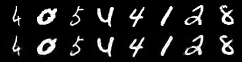

In [51]:
img

In [52]:
img.save('example.png')

In [53]:
sample_size = min(8, z.shape[0])
save_output = torch.clamp(z[:sample_size], -1., 1.).detach().cpu()
save_output = ((save_output + 1) / 2)
save_input = ((z[:sample_size] + 1) / 2).detach().cpu()

grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
img = torchvision.transforms.ToPILImage()(grid)

In [54]:
img

In [55]:
img.save('example_z.png')

In [56]:
torch.save(vqvae_lightning.model.state_dict(), 'vqvae.sd')
torch.save(vqvae_lightning.lpips.state_dict(), 'lpips.sd')
torch.save(vqvae_lightning.discriminator.state_dict(), 'discriminator.sd')

### Train LDM

In [57]:
scheduler = LinearNoiseScheduler(
    num_timesteps=1000,
    beta_start=0.0001,
    beta_end=0.02,
)

In [58]:
x = torch.randn(3, 3, 28, 28)
t = torch.randint(0, 10, (1,))

In [59]:
unet = Unet1(3, 10 + 1)

In [60]:
print(f"The model has {count_parameters(unet):,} trainable parameters")

The model has 21,851,779 trainable parameters


In [61]:
unet(x, t, torch.randint(low=0, high=10, size=(1,))).shape

torch.Size([3, 3, 28, 28])

In [62]:
vae_model = VQVAE(im_channels=1).eval()
vae_model.load_state_dict(torch.load('vqvae.sd'))
for param in vae_model.parameters():
    param.requires_grad = False

In [63]:
ddpm = DDPMLightning(unet, vae_model, scheduler, torch.nn.MSELoss(), 1e-4)

max_epochs = 10
accumulate_grad_batches = 1

In [64]:
trainer = pl.Trainer(
    accelerator='mps',
    # logger=logger,
    # callbacks=[checkpoint_callback, lr_callback],
    max_epochs=max_epochs,
    accumulate_grad_batches=accumulate_grad_batches,
    precision="bf16-mixed",
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=5,
    use_distributed_sampler=True,
)

Using bfloat16 Automatic Mixed Precision (AMP)
💡 Tip: For seamless cloud uploads and versioning, try installing [litmodels](https://pypi.org/project/litmodels/) to enable LitModelCheckpoint, which syncs automatically with the Lightning model registry.
GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores


In [65]:
trainer.fit(
    ddpm,
    train_dataloaders=train_loader,
    # val_dataloaders=valid_loader,
)

/Users/ruasvmv/dl/lib/python3.12/site-packages/pytorch_lightning/utilities/model_summary/model_summary.py:242: Precision bf16-mixed is not supported by the model summary.  Estimated model size in MB will not be accurate. Using 32 bits instead.

  | Name            | Type                 | Params | Mode  | FLOPs
-------------------------------------------------------------------------
0 | unet_model      | Unet1                | 21.9 M | train | 0    
1 | vae_model       | VQVAE                | 10.3 M | eval  | 0    
2 | noise_scheduler | LinearNoiseScheduler | 0      | train | 0    
3 | criterion       | MSELoss              | 0      | train | 0    
-------------------------------------------------------------------------
21.9 M    Trainable params
10.3 M    Non-trainable params
32.2 M    Total params
128.660   Total estimated model params size (MB)
370       Modules in train mode
166       Modules in eval mode
0         Total Flops
/Users/ruasvmv/dl/lib/python3.12/site-packages/pytor

Training: |                                                                                       | 0/? [00:00…

`Trainer.fit` stopped: `max_epochs=10` reached.


In [66]:
torch.save(ddpm.unet_model.state_dict(), 'ldm.sd')

## Sample

In [67]:
train_config = {
    'num_samples': 121,
    'im_channels': 1,
    'im_size': 28,
    'num_grid_rows': 11,
    'task_name': 'mnist',
}
diffusion_config = {
    'num_timesteps': 1000,
}
autoencoder_model_config = {
    'down_sample': [True, True],
    'z_channels': 3,
}
dataset_config = {
    'im_size': 28,
}

In [68]:
def sample(
    unet_model,
    vae,
    scheduler,
    train_config,
    diffusion_config,
    autoencoder_model_config,
    dataset_config,
    device,
):
    """
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])
    xt = torch.randn((train_config['num_samples'],
                      autoencoder_model_config['z_channels'],
                      im_size,
                      im_size), device=device)

    save_count = 0
    for i in tqdm(reversed(range(diffusion_config['num_timesteps'])), total=1000):
        # Get prediction of noise
        noise_pred = unet_model(
            xt,
            torch.as_tensor(i, device=device).unsqueeze(0).repeat(121),
            torch.arange(start=0, end=11, device=device).repeat(11, 1).reshape(-1)
        )
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i, device=device))

        # Save x0
        #ims = torch.clamp(xt, -1., 1.).detach().cpu()
        if i == 0:
            # Decode ONLY the final iamge to save time
            ims = vae.decode(xt)
        else:
            ims = xt
        
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=train_config['num_grid_rows'])
        img = torchvision.transforms.ToPILImage()(grid)

        if i == 0:
            if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
                os.mkdir(os.path.join(train_config['task_name'], 'samples'))
            img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
            img.close()

In [69]:
device = 'mps'

In [70]:
# unet = Unet(1).eval().to(device)
# unet.load_state_dict(torch.load('ldm.sd'))

In [72]:
unet.to(device).eval()
scheduler.to(device)
vae_model.to(device)
''

''

In [73]:
with torch.no_grad():
    sample(unet, vae_model, scheduler, train_config, diffusion_config, autoencoder_model_config, dataset_config, device)

  0%|          | 0/1000 [00:00<?, ?it/s]

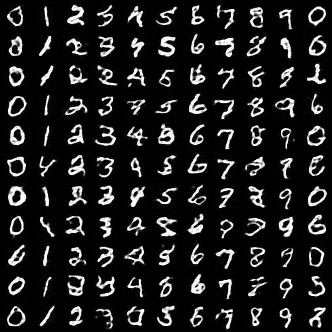

In [74]:
from PIL import Image
Image.open("mnist/samples/x0_0.png")

# Celeb

In [32]:
import os
import glob
import random

from PIL import Image

In [33]:
# import requests

# # Отключаем проверку SSL для всех запросов
# requests.packages.urllib3.disable_warnings(requests.packages.urllib3.exceptions.InsecureRequestWarning)
# os.environ['PYTHONHTTPSVERIFY'] = '0'

In [34]:
# os.environ['HF_HUB_DISABLE_SSL_VERIFICATION'] = '1'
# os.environ['CURL_CA_BUNDLE'] = ''
# os.environ['CURL_CA_BUNDLE'] = ''

In [35]:
# %pip install requests==2.27.1

In [36]:
# %pip install urllib3==1.26.18

In [37]:
# %pip install transformers~=4.51.1

In [38]:
from transformers import DistilBertModel, DistilBertTokenizer

tokenizer = DistilBertTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = DistilBertModel.from_pretrained("distilbert/distilbert-base-uncased").eval()

In [39]:
# tokenizer(['asd', 'zkdkj sjcs cjks'], padding='max_length', max_length=32, truncation=True)

In [40]:
class CelebConditionDataset(Dataset):
    def __init__(
        self,
        im_size: int,
        encoder,
        tokenizer,
    ):
        self.im_size = im_size
        self.encoder = encoder
        self.tokenizer = tokenizer

        images = glob.glob('MM-CELEBA-HQ/images/*')
        
        self.data = dict()
        for i, path in tqdm(enumerate(images), total=len(images)):
            name = os.path.split(path)[1].split('.')[0]
            with open(f'MM-CELEBA-HQ/text/celeba-caption/{name}.txt', 'r') as file:
                captions = file.readlines()
        
            self.data[i] = {
                'name': name,
                'path': path,
                'captions': [c.strip() for c in captions]
            }

        self.transforms = torchvision.transforms.Compose([
            torchvision.transforms.Resize(self.im_size),
            torchvision.transforms.CenterCrop(self.im_size),
            torchvision.transforms.ToTensor(),
            torchvision.transforms.Lambda(lambda x: x * 2 - 1),
        ])

    def __getitem__(self, index) -> tuple:
        sample = self.data[index]
        img = self.transforms(Image.open(sample['path']))
        caption = random.sample(sample['captions'], k=1)[0]

        tokenized = self.tokenizer(
            caption,
            return_tensors='pt',
            padding='max_length',
            max_length=48,
            truncation=True,
        )
        tokenized = {k: v.to('cuda') for k, v in tokenized.items()}
        with torch.no_grad():
            hidden_state = self.encoder(
                **tokenized
            ).last_hidden_state[0]
        return img, hidden_state

    def __len__(self) -> int:
        return len(self.data)

In [41]:
train_dataset = CelebConditionDataset(64, model.to('cuda'), tokenizer)

  0%|          | 0/30000 [00:00<?, ?it/s]

In [42]:
train_dataset[0]

(tensor([[[-0.6549, -0.6627, -0.6706,  ..., -0.4824, -0.4039, -0.5608],
          [-0.6549, -0.6627, -0.6784,  ..., -0.4275, -0.4118, -0.6078],
          [-0.6549, -0.6706, -0.6784,  ..., -0.3647, -0.4667, -0.6471],
          ...,
          [-0.8275, -0.8431, -0.8353,  ..., -0.7490, -0.7569, -0.6784],
          [-0.8196, -0.8275, -0.8275,  ..., -0.7412, -0.7647, -0.7020],
          [-0.8196, -0.8275, -0.8353,  ..., -0.7412, -0.7725, -0.7490]],
 
         [[-0.6627, -0.6784, -0.6941,  ..., -0.3333, -0.3176, -0.4588],
          [-0.6471, -0.6706, -0.6941,  ..., -0.3020, -0.3255, -0.4902],
          [-0.6314, -0.6784, -0.6941,  ..., -0.2784, -0.3490, -0.5059],
          ...,
          [-0.8118, -0.8353, -0.8588,  ..., -0.6863, -0.7098, -0.6157],
          [-0.8275, -0.8353, -0.8510,  ..., -0.6863, -0.7176, -0.6627],
          [-0.8275, -0.8353, -0.8510,  ..., -0.6863, -0.7255, -0.7255]],
 
         [[-0.5216, -0.5608, -0.5843,  ..., -0.6784, -0.6706, -0.6706],
          [-0.4118, -0.5294,

## Loader

In [43]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

In [44]:
for batch in train_loader:
    break

In [45]:
batch[0].shape, batch[1].shape

(torch.Size([32, 3, 64, 64]), torch.Size([32, 48, 768]))

## Train

### Train VQVAE

In [46]:
vqvae = VQVAE(im_channels=3)
lpips = LPIPS()
discriminator = Discriminator(im_channels=3)

vqvae_lightning = VQVAELightning(
    vqvae,
    discriminator,
    lpips,
    1e-5,
)

In [47]:
count_parameters(vqvae_lightning)

24296751

In [48]:
for batch in train_loader:
    break

In [49]:
batch[0].shape

torch.Size([32, 3, 64, 64])

In [50]:
# vqvae(batch[0])[0].shape

In [51]:
max_epochs = 20
acc_steps = 1

In [52]:
trainer = pl.Trainer(
    accelerator='cuda',
    precision='bf16-mixed',
    max_epochs=max_epochs,
    accumulate_grad_batches=acc_steps,
    # gradient_clip_val=5,
    log_every_n_steps=20,
    deterministic=True,
)

trainer.fit(
    vqvae_lightning,
    train_dataloaders=train_loader,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA RTX A6000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type          | Params | Mode 
----------------------------------------------------------
0 | model           | VQVAE         | 23.6 M | train
1 | discriminator   | Discriminator | 663 K  | train
2 | lpips           | LPIPS         | 14.7 M | train
3 | recon_criterion | MSELoss       | 0      | train
4 | disc_criterion  | MSELoss       | 0      | train
----------------------------------------------------------
2

Training: |                                               | 0/? [00:00<?, ?it/s]

/home/max/common/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:213: You called `self.log('train_d_loss', ...)` in your `training_step` but the value needs to be floating to be reduced. Converting it to torch.float32. You can silence this warning by converting the value to floating point yourself. If you don't intend to reduce the value (for instance when logging the global step or epoch) then you can use `self.logger.log_metrics({'train_d_loss': ...})` instead.
`Trainer.fit` stopped: `max_epochs=20` reached.


In [53]:
from torchvision.utils import make_grid

In [54]:
vqvae_lightning.eval()
im = batch[0]
output, z, quantize_losses = vqvae_lightning(batch[0])

sample_size = min(8, im.shape[0])
save_output = torch.clamp(output[:sample_size], -1., 1.).detach().cpu()
save_output = ((save_output + 1) / 2)
save_input = ((im[:sample_size] + 1) / 2).detach().cpu()

grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
img = torchvision.transforms.ToPILImage()(grid)

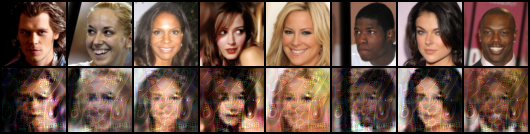

In [55]:
img

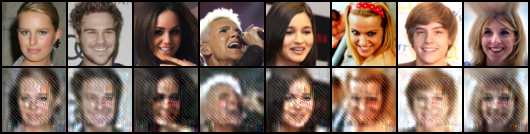

In [64]:
img

In [56]:
img.save('example_celeb.png')

In [57]:
sample_size = min(8, z.shape[0])
save_output = torch.clamp(z[:sample_size], -1., 1.).detach().cpu()
save_output = ((save_output + 1) / 2)
save_input = ((z[:sample_size] + 1) / 2).detach().cpu()

grid = make_grid(torch.cat([save_input, save_output], dim=0), nrow=sample_size)
img = torchvision.transforms.ToPILImage()(grid)

In [58]:
img

In [59]:
img.save('example_z_celeb.png')

In [60]:
torch.save(vqvae_lightning.model.state_dict(), 'vqvae_celeb.sd')
torch.save(vqvae_lightning.lpips.state_dict(), 'lpips_celeb.sd')
torch.save(vqvae_lightning.discriminator.state_dict(), 'discriminator_celeb.sd')

### Train LDM

In [61]:
scheduler = LinearNoiseScheduler(
    num_timesteps=1000,
    beta_start=0.00085,
    beta_end=0.018,
)

In [62]:
x = torch.randn(3, 3, 28, 28)
t = torch.randint(0, 10, (1,))

In [70]:
unet = Unet2(4)

In [71]:
print(f"The model has {count_parameters(unet):,} trainable parameters")

The model has 124,771,332 trainable parameters


In [72]:
# unet(x, t, torch.randint(low=0, high=10, size=(1,))).shape

In [73]:
vae_model = VQVAE(im_channels=3).eval()
vae_model.load_state_dict(torch.load('vqvae_celeb.sd'))
for param in vae_model.parameters():
    param.requires_grad = False

In [74]:
ddpm = DDPMLightning(unet, vae_model, scheduler, torch.nn.MSELoss(), 0.000005)

max_epochs = 100
accumulate_grad_batches = 1

In [75]:
trainer = pl.Trainer(
    accelerator='cuda',
    # logger=logger,
    # callbacks=[checkpoint_callback, lr_callback],
    max_epochs=max_epochs,
    accumulate_grad_batches=accumulate_grad_batches,
    precision="bf16-mixed",
    log_every_n_steps=1,
    enable_checkpointing=True,
    enable_progress_bar=True,
    gradient_clip_val=5,
    use_distributed_sampler=True,
)

Using bfloat16 Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


In [76]:
trainer.fit(
    ddpm,
    train_dataloaders=train_loader,
    # val_dataloaders=valid_loader,
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name            | Type                 | Params | Mode 
-----------------------------------------------------------------
0 | unet_model      | Unet2                | 124 M  | train
1 | vae_model       | VQVAE                | 23.6 M | eval 
2 | noise_scheduler | LinearNoiseScheduler | 0      | train
3 | criterion       | MSELoss              | 0      | train
-----------------------------------------------------------------
124 M     Trainable params
23.6 M    Non-trainable params
148 M     Total params
593.613   Total estimated model params size (MB)
446       Modules in train mode
312       Modules in eval mode


Training: |                                               | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


In [89]:
train_config = {
    'num_samples': 121,
    'im_channels': 3,
    'im_size': 64,
    'num_grid_rows': 11,
    'task_name': 'MM-CELEBA-HQ',
}
diffusion_config = {
    'num_timesteps': 1000,
}
autoencoder_model_config = {
    'down_sample': [True, True, True],
    'z_channels': 4,
}
dataset_config = {
    'im_size': 64,
}

In [93]:
def sample(model, scheduler, train_config, diffusion_model_config,
           autoencoder_model_config, diffusion_config, dataset_config, vae, text_tokenizer, text_model):
    r"""
    Sample stepwise by going backward one timestep at a time.
    We save the x0 predictions
    """
    device = 'cuda'
    im_size = dataset_config['im_size'] // 2 ** sum(autoencoder_model_config['down_sample'])
    
    ########### Sample random noise latent ##########
    # For not fixing generation with one sample
    xt = torch.randn((1,
                      autoencoder_model_config['z_channels'],
                      im_size,
                      im_size)).to(device)
    ###############################################
    
    ############ Create Conditional input ###############
    text_prompt = ['She is a woman with blond hair. She is wearing lipstick.']
    neg_prompt = ['He is a man.']
    empty_prompt = ['']

    tokenized = text_tokenizer(
        text_prompt,
        return_tensors='pt',
        padding='max_length',
        max_length=48,
        truncation=True,
    )
    tokenized = {k: v.to('cuda') for k, v in tokenized.items()}
    text_prompt_embed = text_model(
        **tokenized
    ).last_hidden_state
    # text_prompt_embed = get_text_representation(text_prompt,
    #                                             text_tokenizer,
    #                                             text_model,
    #                                             device)
    # Can replace empty prompt with negative prompt
    # empty_text_embed = get_text_representation(empty_prompt, text_tokenizer, text_model, device)
    tokenized = text_tokenizer(
        neg_prompt,
        return_tensors='pt',
        padding='max_length',
        max_length=48,
        truncation=True,
    )
    tokenized = {k: v.to('cuda') for k, v in tokenized.items()}
    empty_text_embed = text_model(
        **tokenized
    ).last_hidden_state
    assert empty_text_embed.shape == text_prompt_embed.shape
    
    uncond_input = {
        'text': empty_text_embed
    }
    cond_input = {
        'text': text_prompt_embed
    }
    ###############################################
    
    # By default classifier free guidance is disabled
    # Change value in config or change default value here to enable it
    cf_guidance_scale = 1.0
    
    ################# Sampling Loop ########################
    for i in tqdm(reversed(range(diffusion_config['num_timesteps']))):
        # Get prediction of noise
        t = (torch.ones((xt.shape[0],)) * i).long().to(device)
        noise_pred_cond = model(xt, t, text_prompt_embed)
        
        if cf_guidance_scale > 1:
            noise_pred_uncond = model(xt, t, empty_text_embed)
            noise_pred = noise_pred_uncond + cf_guidance_scale * (noise_pred_cond - noise_pred_uncond)
        else:
            noise_pred = noise_pred_cond
        
        # Use scheduler to get x0 and xt-1
        xt, x0_pred = scheduler.sample_prev_timestep(xt, noise_pred, torch.as_tensor(i).to(device))
        
        # Save x0
        # ims = torch.clamp(xt, -1., 1.).detach().cpu()
        if i == 0:
            # Decode ONLY the final iamge to save time
            ims = vae.decode(xt)
        else:
            ims = x0_pred
        
        ims = torch.clamp(ims, -1., 1.).detach().cpu()
        ims = (ims + 1) / 2
        grid = make_grid(ims, nrow=1)
        img = torchvision.transforms.ToPILImage()(grid)
        
        if i == 0:
            if not os.path.exists(os.path.join(train_config['task_name'], 'samples')):
                os.mkdir(os.path.join(train_config['task_name'], 'samples'))
            img.save(os.path.join(train_config['task_name'], 'samples', 'x0_{}.png'.format(i)))
            img.close()

In [94]:
device = 'cuda'
unet.to(device).eval()
scheduler.to(device)
vae_model.to(device)
''

''

In [95]:
with torch.no_grad():
    sample(unet, scheduler, train_config, diffusion_config,
           autoencoder_model_config, diffusion_config, dataset_config, vae_model, tokenizer, model)

0it [00:00, ?it/s]